<a href="https://colab.research.google.com/github/julianopadua/Aumento-ou-Diminuicao-Dolar/blob/main/Previsao_Aumento_Diminuicao_Dolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introdução**

##Dando continuidade no projeto feito anteriormente, decidi mudar a abordagem.
##Neste notebook, eu tentarei prever apenas se a cotação do dólar aumentará ou diminuirá no dia seguinte. Para tal, preparei o dataset da cotação, adicionando a coluna "Amanha" que é o valor da cotação no dia seguinte, e a coluna "Target", que dita se a cotação aumenta ou diminui no dia seguinte.

#**Primeira Parte**

##Na primeira parte, aplico o modelo Random Forest Classifier para tentar prever se a cotação aumentará ou diminuirá no dia seguinte. Obtive uma precisão de aproximadamente 60%, o que é "bom", visto que, a longo prazo, o algoritmo acerta mais do que erra, o que significa lucro para um investidor

In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import os

In [2]:
dolar = yf.Ticker("USDBRL=X")
dolar = dolar.history(period="max")
dolar

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-01 00:00:00+00:00,2.94600,2.9460,2.923000,2.92300,0,0.0,0.0
2003-12-02 00:00:00+00:00,2.92300,2.9310,2.923000,2.93100,0,0.0,0.0
2003-12-03 00:00:00+00:00,2.93100,2.9360,2.926000,2.93100,0,0.0,0.0
2003-12-04 00:00:00+00:00,2.93100,2.9430,2.931000,2.94300,0,0.0,0.0
2003-12-05 00:00:00+00:00,2.94300,2.9480,2.934000,2.93400,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-11 00:00:00+00:00,4.97754,4.9975,4.959800,4.97754,0,0.0,0.0
2024-03-12 00:00:00+00:00,4.97740,4.9919,4.958000,4.97740,0,0.0,0.0
2024-03-13 00:00:00+00:00,4.96870,4.9858,4.948557,4.96870,0,0.0,0.0


In [3]:
dolar.index = pd.to_datetime(dolar.index)
del dolar["Dividends"]
del dolar["Stock Splits"]
del dolar["Volume"]

dolar["Amanha"] = dolar["Close"].shift(-1)
dolar["Target"] = (dolar["Amanha"] > dolar["Close"]).astype(int)
dolar = dolar.loc["2003-12-01":].copy()

dolar.head(5)

,Open,High,Low,Close,Amanha,Target
Date,,,,,,
2003-12-01 00:00:00+00:00,2.946,2.946,2.923,2.923,2.931,1
2003-12-02 00:00:00+00:00,2.923,2.931,2.923,2.931,2.931,0
2003-12-03 00:00:00+00:00,2.931,2.936,2.926,2.931,2.943,1
2003-12-04 00:00:00+00:00,2.931,2.943,2.931,2.943,2.934,0
2003-12-05 00:00:00+00:00,2.943,2.948,2.934,2.934,2.940,1


In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = dolar.iloc[:-100]
test = dolar.iloc[-100:]

predictors = ["Close", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [5]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6

<Axes: xlabel='Date'>

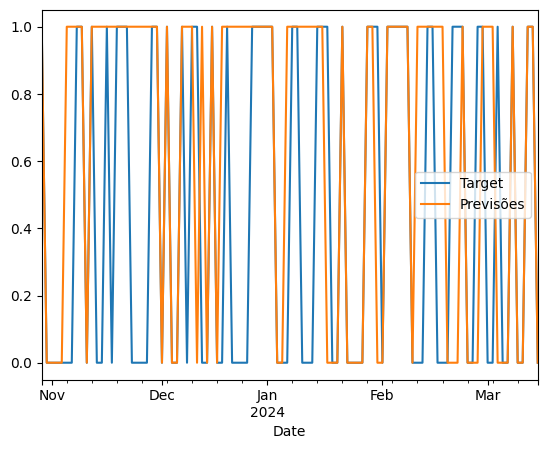

In [6]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ['Target', 'Previsões']
combined.plot()

#**Segunda Parte**

##Na segunda parte, decidi incluir mais variáveis para a classificação. Adicionei as anteriormente utilizadas Ibovespa e ICE U.S. Dollar, e, como novidades, as commodities: Café, Milho, Açucar, Petróleo Cru e Ouro. Entendi que se tratam de mercadorias de alto impacto na nossa economia. A página oficial do ICB B3, que trás informações sobre o assunto, me ajudou bastante.

##Entretanto, deixo como adendo: os ativos das commodities utilizados são com base no mercado americano, o que torna meu estudo não tão acurado para com o mercado brasileiro. Os ativos e índices que eu procurei e queria utilizar no meu projeto estão disponíveis apenas por API`s de assinatura mensal, o que foge da minha realidade como estudante.

##Mas, com essa nova configuração, o resultado foi um aumento no score da previsão, subindo para aproximadamente 80%!
##Isso demonstra o peso do mercado de commodities na relação dólar-real, o que já era esperado, visto que ambos países produzem/consomem muito tais mercadorias.

In [7]:
def df_acao(ticker):
  acao = yf.download(ticker, dt.datetime(2003, 1, 1), dt.datetime.now())['Close']
  return acao

In [8]:
ibovespa = df_acao("^BVSP")
ice_usdolar = df_acao("DX-Y.NYB")
acucar = df_acao("SB=F")
milho = df_acao("ZC=F")
cafe = df_acao("KC=F")
petroleo = df_acao("CL=F")
ouro = df_acao("GC=F")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
dolar.index = pd.to_datetime(dolar.index.strftime('%Y-%m-%d'))
ibovespa.index = pd.to_datetime(ibovespa.index.strftime('%Y-%m-%d'))
ice_usdolar.index = pd.to_datetime(ice_usdolar.index.strftime('%Y-%m-%d'))
acucar.index = pd.to_datetime(acucar.index.strftime('%Y-%m-%d'))
milho.index = pd.to_datetime(milho.index.strftime('%Y-%m-%d'))
cafe.index = pd.to_datetime(cafe.index.strftime('%Y-%m-%d'))
petroleo.index = pd.to_datetime(petroleo.index.strftime('%Y-%m-%d'))
ouro.index = pd.to_datetime(ouro.index.strftime('%Y-%m-%d'))

In [10]:
def preencher_serie_com_ultimo_valor(serie, inicio):
    #gera o novo indice
    novo_indice = pd.date_range(start=inicio, end=pd.Timestamp.today(), freq='D')

    #substui o indice, e preenche valores nao existentes pelo ultimo valor existente
    serie_preenchida = serie.reindex(novo_indice, method='ffill')

    return serie_preenchida

In [11]:
dolar = preencher_serie_com_ultimo_valor(dolar, '2003-12-01')
ibovespa = preencher_serie_com_ultimo_valor(ibovespa, "2003-12-01")
ice_usdolar = preencher_serie_com_ultimo_valor(ice_usdolar, "2003-12-01")
acucar = preencher_serie_com_ultimo_valor(acucar, "2003-12-01")
milho = preencher_serie_com_ultimo_valor(milho, "2003-12-01")
cafe = preencher_serie_com_ultimo_valor(cafe, "2003-12-01")
petroleo = preencher_serie_com_ultimo_valor(petroleo, "2003-12-01")
ouro = preencher_serie_com_ultimo_valor(ouro, "2003-12-01")

In [12]:
'''
  Função que recebe uma serie e transforma seus valores em 0 ou 1
  1 para quando o valor atual é maior que o valor anterior
  0 para quando o valor atual é menor ou igual ao valor anterior.

  Apliquei ela nos dados históricos do Ibovespa e do ICE U.S. Dollar
  porque entendi que, para a classificação de se a cotação do dólar
  vai aumentar ou diminuir no dia seguinte, o modelo irá correlacionar
  melhor o aumento ou não de tais índices, invés do valor de fato deles.
'''

def detectar_aumento(serie):
    resultados = [0]

    for i in range(1, len(serie)):
        if serie[i] > serie[i-1]:
            resultados.append(1)
        else:
            resultados.append(0)

    serie_resultados = pd.Series(resultados, index=serie.index)

    return serie_resultados


In [13]:
ibovespa = detectar_aumento(ibovespa)

In [14]:
ice_usdolar = detectar_aumento(ice_usdolar)

In [15]:
ibovespa.name = "Aumento Ibovespa"
ice_usdolar.name = "Aumento ICE"
cafe.name = "Close_Cafe"
milho.name = "Close_Milho"
acucar.name = "Close_Açucar"
petroleo.name = "Close_Petróleo"
ouro.name = "Close_Ouro"

In [25]:
df = pd.concat([ice_usdolar, ibovespa, ouro, cafe, milho, acucar, petroleo, dolar], axis = 1)
df

,Aumento ICE,Aumento Ibovespa,Close_Ouro,Close_Cafe,Close_Milho,Close_Açucar,Close_Petróleo,Open,High,Low,Close,Amanha,Target
2003-12-01,0,0,402.700012,59.599998,246.50,6.290000,29.950001,2.94600,2.9460,2.923000,2.92300,2.9310,1
2003-12-02,0,0,403.700012,62.000000,245.75,6.380000,30.780001,2.92300,2.9310,2.923000,2.93100,2.9310,0
2003-12-03,0,1,403.899994,62.500000,249.25,6.580000,31.100000,2.93100,2.9360,2.926000,2.93100,2.9430,1
2003-12-04,1,0,403.299988,60.950001,246.75,6.710000,31.260000,2.93100,2.9430,2.931000,2.94300,2.9340,0
2003-12-05,0,1,406.399994,61.900002,246.50,6.650000,30.730000,2.94300,2.9480,2.934000,2.93400,2.9400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,1,0,2182.500000,194.350006,428.25,21.950001,77.930000,4.97754,4.9975,4.959800,4.97754,4.9774,0
2024-03-12,1,1,2160.399902,195.399994,429.00,21.889999,77.559998,4.97740,4.9919,4.958000,4.97740,4.9687,0
2024-03-13,0,1,2175.399902,191.649994,426.50,21.930000,79.720001,4.96870,4.9858,4.948557,4.96870,4.9692,1
2024-03-14,1,0,2163.000000,191.350006,422.50,21.770000,81.260002,4.96920,4.9806,4.952065,4.96920,4.9867,1


In [26]:
predictors = df.columns[:-2].tolist()
predictors

['Aumento ICE',
 'Aumento Ibovespa',
 'Close_Ouro',
 'Close_Cafe',
 'Close_Milho',
 'Close_Açucar',
 'Close_Petróleo',
 'Open',
 'High',
 'Low',
 'Close']

In [27]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [28]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.8

<Axes: >

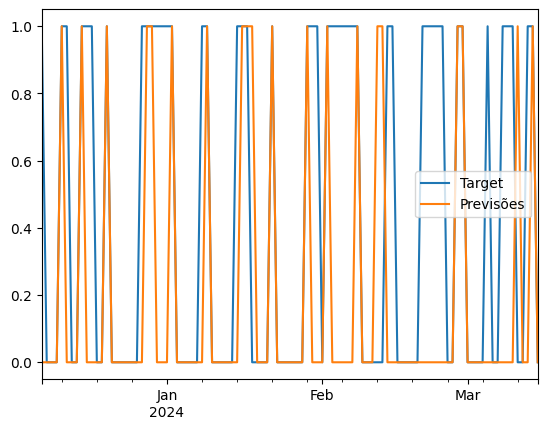

In [29]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ['Target', 'Previsões']
combined.plot()